In [33]:
import os
import hydra
import logging
import pandas as pd
import joblib
import warnings
import rootutils
import numpy as np
from pathlib import Path
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from sklearn.metrics import f1_score

rootutils.setup_root(search_from="../", indicator=".project-root", pythonpath=True)

from src.experiment.utils import (
    assign_fold_index,
    plot_confusion_matrix,
    visualize_feature_importance,
    plot_label_distributions,
)
from src.experiment.feature.runner import run_extractors
from src.experiment.metrics import macro_f1_from_proba
from src.experiment.model.runner import train_cv_tabular_v1, predict_cv_tabular_v1
from src.experiment.optimization import find_optimal_threshold_for_label, decode_label

In [34]:
OVERRIDES: list[str] = os.getenv("OVERRIDES", "experiment=003-tabular_v2").split(",")

In [40]:
if OVERRIDES is None:
    raise ValueError("OVERRIDES is not set")

with initialize(version_base=None, config_path="../configs"):
    CFG = compose(
        config_name="config.yaml",
        return_hydra_config=True,
        overrides=OVERRIDES,
    )
    HydraConfig.instance().set_config(CFG)  # use HydraConfig for notebook to use hydra job

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

if not logger.handlers:
    handler = logging.StreamHandler()
    logger.addHandler(handler)


warnings.filterwarnings("ignore")
INPUT_DIR = Path(CFG.paths.input_dir)
OUTPUT_DIR = Path(CFG.paths.output_dir)

Setting JobRuntime:name=notebook


### Load Data


In [36]:
def assign_meta(df: pd.DataFrame, data="train"):
    df["data"] = data
    df["fold"] = -1
    return df


train_df = pd.read_csv(INPUT_DIR / "train.csv").rename(columns={"Unnamed: 0": "uid"})
test_df = pd.read_csv(INPUT_DIR / "test.csv").rename(columns={"Unnamed: 0": "uid"})
sample_submission_df = pd.read_csv(INPUT_DIR / "sample_submission.csv")

train_df = assign_meta(train_df, data="train")
test_df = assign_meta(test_df, data="test")

### CV Split


In [37]:
kfold = hydra.utils.instantiate(CFG.cv)
train_df = assign_fold_index(train_df=train_df, kfold=kfold, y_col="health")

### Feature Engineering


In [38]:
feature_extractors = hydra.utils.instantiate(CFG.feature_extractors)

for extractor in CFG.agg_feature_extractors:
    if CFG.group_keys_for_agg is not None:
        for group_keys in CFG.group_keys_for_agg:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            feature_extractors.append(_extractor)

for extractor in CFG.te_feature_extractors:
    if CFG.group_keys_for_te is not None:
        for group_keys in CFG.group_keys_for_te:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            feature_extractors.append(_extractor)

raw_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
raw_feature_df = run_extractors(
    input_df=raw_df,
    extractors=feature_extractors,
    dirpath=Path(CFG.paths.feature_store_dir),
    fit=True,
    cache=CFG.cache_feature_extractors,
)
assert len(raw_df) == len(raw_feature_df)

raw_feature_df = pd.concat([raw_df, raw_feature_df], axis=1)
train_feature_df = raw_feature_df.query("data == 'train'").reset_index(drop=True)
test_feature_df = raw_feature_df.query("data == 'test'").reset_index(drop=True)

feature_columns = [col for col in train_feature_df.columns if col.startswith("f_")]

<CreatedAtFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<CurbLocationFeatureExtractorV1_ffb6a02e825b9d360512f969787b1224531b252c126bdfe37bcd16e4bc25f9e8>
<StreetWidthFeatureExtractorV1_e1934d345bbdbad6b6f154ab09d29008992672b28417152d8b0cc4d67cf97d52>
<GuardsFeatureExtractorV1_32effaf7c5b3c0140641140dbe7f670e6864cab220e3ce069c29ba661bbb756d>
<SidewalkFeatureExtractorV1_11ff165eda5af11f1928f4588c36bd9dd7a3197cf1f18f4f1d741ebc6292d04e>
<UserTypeFeatureExtractorV1_807ed6f844d318d70e501ed5fcef4e2324682fd3d8bd67d9ce65f98c8fd9468f>
<ProblemsFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<NtaFeatureExtractorV1_86ddbf901e5c7d2d0ebdda417de8e509407566f742f2645a8e164e236d91989b>
<RawTransformer_ad8f3c0e9af5e37117606a7a14ec4cd3c9595632f93afd5cf9b1a4eea53b0bf5>
<CreatedAtFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<TreeDbhFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe

### Train


In [58]:
def assign_seed_average_pred(result_df: pd.DataFrame) -> pd.DataFrame:
    cols = [col for col in result_df.columns if col.startswith("pred_")]
    pred = 0
    for col in cols:
        pred += np.array(result_df[col].tolist())
    result_df["pred"] = list(pred / len(cols))
    return result_df.reset_index()


valid_result_df = pd.DataFrame()
all_trained_estimators = []
for seed in CFG.seed_average_seeds:
    logger.info(f"\n\nstart training seed={seed} 🚀")
    CFG.model.estimator.random_state = seed

    if CFG.use_cat_features:
        cat_features = [x for x in feature_columns if x.startswith("f_oe_")]
        estimator = hydra.utils.instantiate(CFG.model.estimator, cat_features=cat_features)
    else:
        estimator = hydra.utils.instantiate(CFG.model.estimator)
    fit_params = hydra.utils.instantiate(CFG.model.fit_params)

    model_output_dir = OUTPUT_DIR / "models" / f"seed{seed}"
    trained_estimators = train_cv_tabular_v1(
        df=train_feature_df,
        estimator=estimator,
        feature_columns=feature_columns,
        target_columns=["health"],
        fit_params=fit_params,
        output_dir=model_output_dir,
        overwrite=CFG.overwrite_training,
    )

    i_valid_result_df = predict_cv_tabular_v1(
        df=train_feature_df,
        estimators=trained_estimators,
        feature_columns=feature_columns,
    )
    val_score = macro_f1_from_proba(
        y_true=i_valid_result_df["health"],
        y_pred=i_valid_result_df["pred"].tolist(),
    )
    logger.info(f"macro f1 score [seed={seed}]: {val_score}")

    valid_result_df = pd.concat(
        [
            valid_result_df,
            i_valid_result_df[["uid", "pred", "health"]]
            .set_index(["uid", "health"])
            .rename(columns={"pred": f"pred_{seed}"}),
        ],
        axis=1,
    )
    all_trained_estimators.extend(trained_estimators)


valid_result_df = assign_seed_average_pred(valid_result_df)
val_proba = np.array(valid_result_df["pred"].tolist())
val_score = macro_f1_from_proba(y_true=valid_result_df["health"], y_pred=val_proba)

opt_results, val_pred_label = find_optimal_threshold_for_label(
    proba_matrix=val_proba,
    true_labels=valid_result_df["health"],
    label_indices=[2, 0, 1],
)
best_f1_score = f1_score(
    y_true=valid_result_df["health"],
    y_pred=val_pred_label,
    average="macro",
)

logger.info(f"macro f1 score: {val_score}")
logger.info(f"optimized thresholds: {opt_results}")
logger.info(f"best f1 score: {best_f1_score}")



start training seed=0 🚀
start training fold=0 🚀 
estimator : LGBMClassifier_3cad0b6470ee2b398f9ed09d31fa98db3d9020881159b8ca26d3041a1732d29a


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41654
[LightGBM] [Info] Number of data points in the train set: 821, number of used features: 528
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds


start training fold=1 🚀 
estimator : LGBMClassifier_3cad0b6470ee2b398f9ed09d31fa98db3d9020881159b8ca26d3041a1732d29a


[100]	valid_0's multi_logloss: 0.746104
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.694538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40964
[LightGBM] [Info] Number of data points in the train set: 759, number of used features: 528
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds


start training fold=2 🚀 
estimator : LGBMClassifier_3cad0b6470ee2b398f9ed09d31fa98db3d9020881159b8ca26d3041a1732d29a


[100]	valid_0's multi_logloss: 0.721954
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.660414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41294
[LightGBM] [Info] Number of data points in the train set: 795, number of used features: 528
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.62478
Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.615316


start training fold=3 🚀 
estimator : LGBMClassifier_3cad0b6470ee2b398f9ed09d31fa98db3d9020881159b8ca26d3041a1732d29a


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41595
[LightGBM] [Info] Number of data points in the train set: 805, number of used features: 528
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds


start training fold=4 🚀 
estimator : LGBMClassifier_3cad0b6470ee2b398f9ed09d31fa98db3d9020881159b8ca26d3041a1732d29a


[100]	valid_0's multi_logloss: 0.838064
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.747456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41646
[LightGBM] [Info] Number of data points in the train set: 820, number of used features: 528
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds


fold0 predict : test=False
fold1 predict : test=False
fold2 predict : test=False
fold3 predict : test=False
fold4 predict : test=False


[100]	valid_0's multi_logloss: 0.917592
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.779817


macro f1 score [seed=0]: 0.3334228572250435


start training seed=1 🚀
start training fold=0 🚀 
estimator : LGBMClassifier_d3eb8c947832544703e922ab1a39a7682c8d409989eef6c0f3db11f366c0f163


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41654
[LightGBM] [Info] Number of data points in the train set: 821, number of used features: 528
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds


start training fold=1 🚀 
estimator : LGBMClassifier_d3eb8c947832544703e922ab1a39a7682c8d409989eef6c0f3db11f366c0f163


[100]	valid_0's multi_logloss: 0.718503
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.664001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40964
[LightGBM] [Info] Number of data points in the train set: 759, number of used features: 528
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds


start training fold=2 🚀 
estimator : LGBMClassifier_d3eb8c947832544703e922ab1a39a7682c8d409989eef6c0f3db11f366c0f163


[100]	valid_0's multi_logloss: 0.722081
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.650986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41294
[LightGBM] [Info] Number of data points in the train set: 795, number of used features: 528
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds


start training fold=3 🚀 


[100]	valid_0's multi_logloss: 0.651458
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.638974


estimator : LGBMClassifier_d3eb8c947832544703e922ab1a39a7682c8d409989eef6c0f3db11f366c0f163


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41595
[LightGBM] [Info] Number of data points in the train set: 805, number of used features: 528
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds


start training fold=4 🚀 
estimator : LGBMClassifier_d3eb8c947832544703e922ab1a39a7682c8d409989eef6c0f3db11f366c0f163


[100]	valid_0's multi_logloss: 0.832854
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.749902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41646
[LightGBM] [Info] Number of data points in the train set: 820, number of used features: 528
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds


fold0 predict : test=False
fold1 predict : test=False
fold2 predict : test=False
fold3 predict : test=False
fold4 predict : test=False


[100]	valid_0's multi_logloss: 0.888725
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.760541


macro f1 score [seed=1]: 0.3478529582022296
macro f1 score: 0.3551235289469093
optimized thresholds: {2: {'threshold': 0.20202020202020204, 'f1': 0.3700132085916133}, 0: {'threshold': 0.36363636363636365, 'f1': 0.3775159168181943}, 1: {'threshold': 0.0, 'f1': 0.3775159168181943}}
best f1 score: 0.3775159168181943


In [ ]:
joblib.dump(valid_result_df[["uid", "pred"]], OUTPUT_DIR / "valid_result_df.pkl")

### Visualization


locator: <matplotlib.ticker.AutoLocator object at 0x7f97f03e7850>
locator: <matplotlib.ticker.AutoLocator object at 0x7f97dbfeff10>


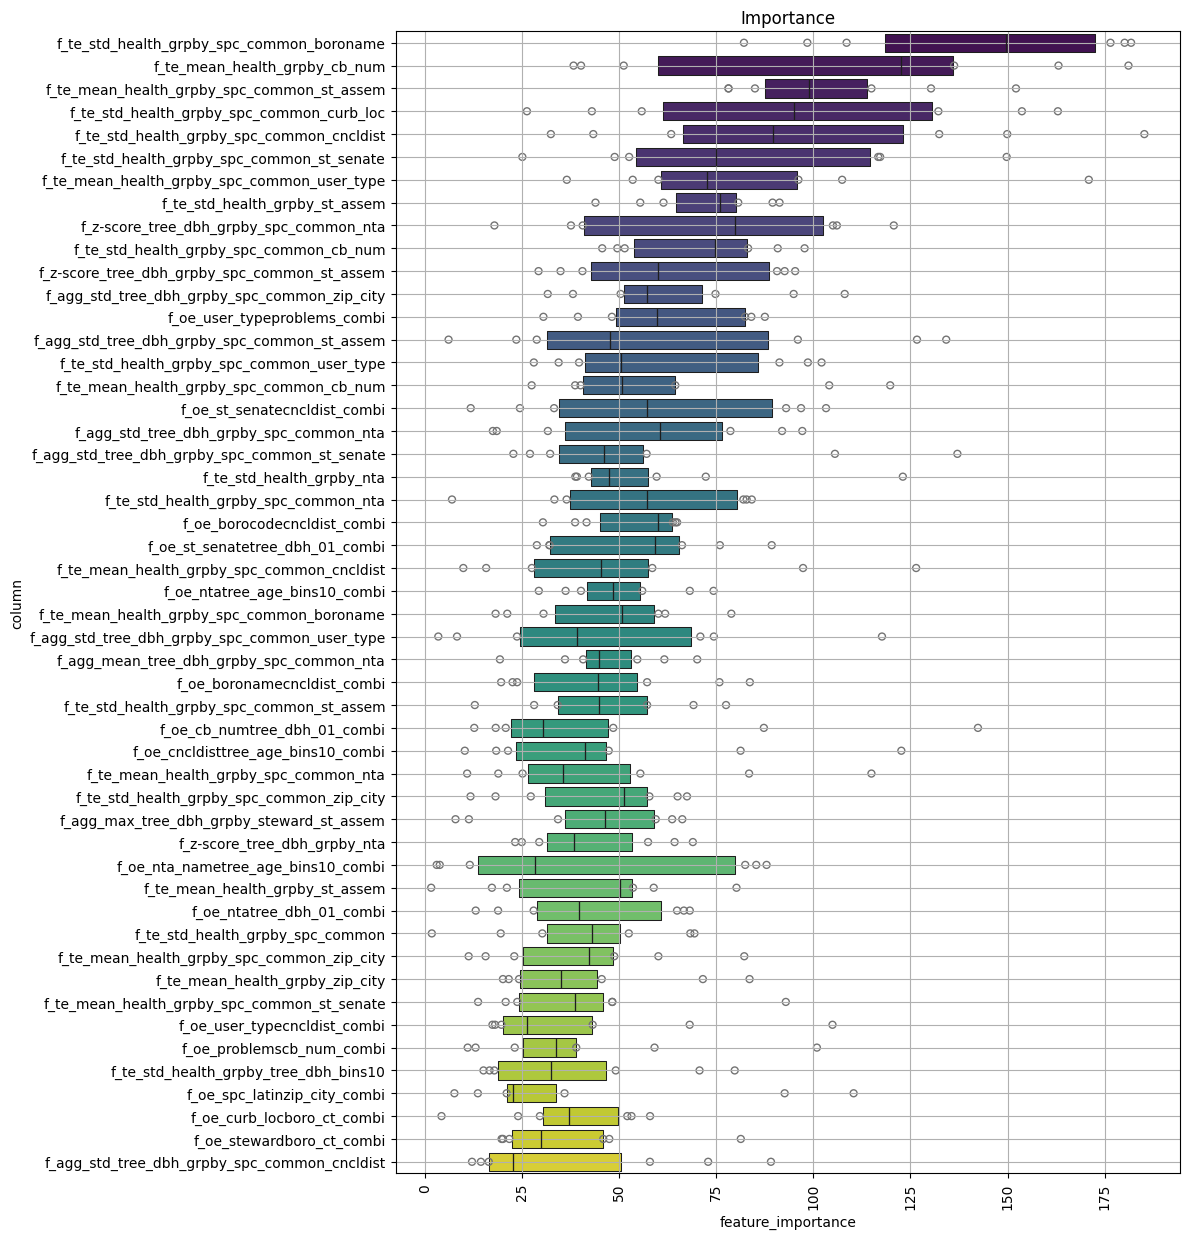

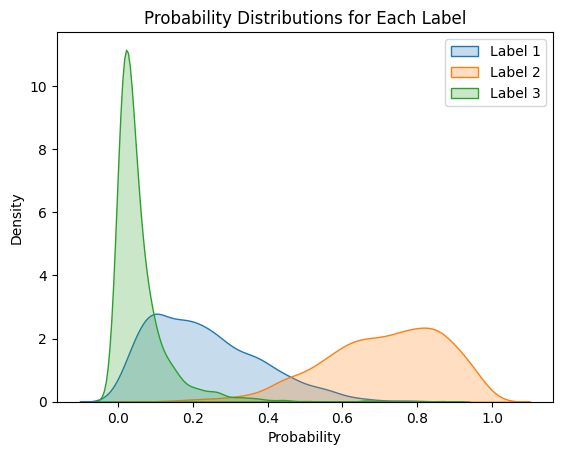

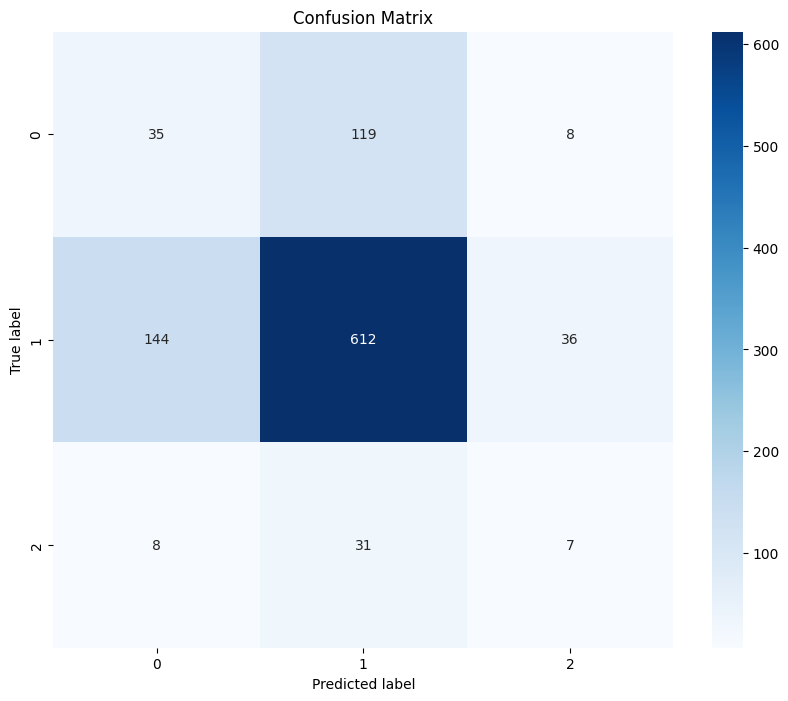

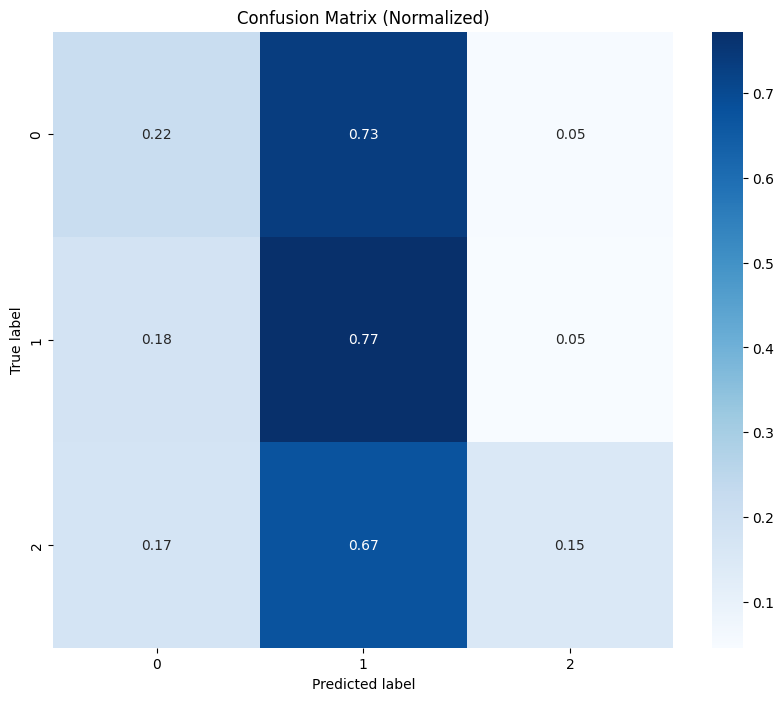

In [59]:
fig, importance_df = visualize_feature_importance(
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    top_n=50,
)
fig.savefig(OUTPUT_DIR / "feature_importance.png", dpi=300)
importance_df.to_csv(OUTPUT_DIR / "feature_importance.csv", index=False)


fig = plot_label_distributions(proba_matrix=np.array(valid_result_df["pred"].tolist()))
fig.show()
fig.savefig(OUTPUT_DIR / "label_distributions.png", dpi=300)


fig = plot_confusion_matrix(y_true=valid_result_df["health"], y_pred=val_pred_label)
fig.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=300)

fig = plot_confusion_matrix(y_true=valid_result_df["health"], y_pred=val_pred_label, normalize=True)
fig.savefig(OUTPUT_DIR / "confusion_matrix_normalized.png", dpi=300)

### Make submission


In [60]:
test_result_df = predict_cv_tabular_v1(
    df=test_feature_df,
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    test=True,
)

test_pred_df = pd.concat([test_result_df[["uid"]], pd.DataFrame(test_result_df["pred"].tolist())], axis=1)
test_df["pred"] = np.argmax(test_pred_df.groupby("uid").mean(), axis=1)
submission_df = test_df[["uid", "pred"]]
submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}.csv"
submission_df.to_csv(submission_filepath, index=False, header=False)

fold0 predict : test=True
fold1 predict : test=True
fold2 predict : test=True
fold3 predict : test=True
fold4 predict : test=True
fold5 predict : test=True
fold6 predict : test=True
fold7 predict : test=True
fold8 predict : test=True
fold9 predict : test=True


In [11]:
test_pred_df = pd.concat([test_result_df[["uid"]], pd.DataFrame(test_result_df["pred"].tolist())], axis=1)
test_df["opt_pred"] = decode_label(proba_matrix=test_pred_df.groupby("uid").mean().to_numpy(), thresholds=opt_results)

submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}_opt.csv"
test_df[["uid", "opt_pred"]].to_csv(submission_filepath, index=False, header=False)